<a href="https://colab.research.google.com/github/alanspace/Python_for_stock/blob/main/Stock_price_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Description
# The program uses an artifical Recurrent Nerual Network (RNN) called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation, like Apple Inc. using the past 60 day stock price. 

# https://www.youtube.com/watch?v=QIUxPv5PJOY

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# Get the stock quote
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2020-12-30')
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.737655
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.879071
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013705
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.993064
...,...,...,...,...,...,...
2020-12-23,132.429993,130.779999,132.160004,130.960007,88223700.0,130.960007
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.970001
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.690002


In [ ]:
  # Get the number of rowsa and columns in the dataset 
  df.shape

(2264, 6)

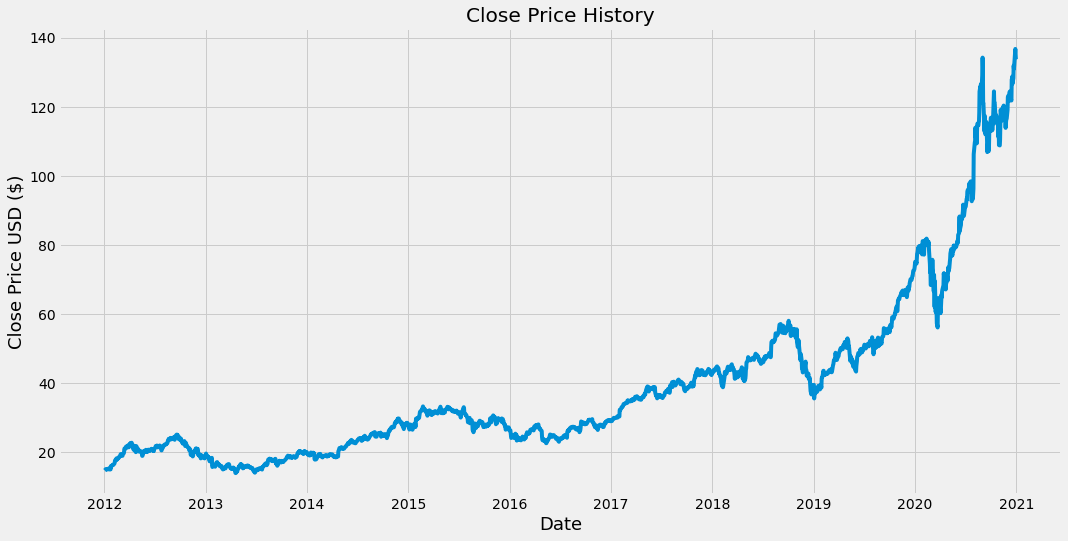

In [ ]:
# Visusalize the closing price history
plt.figure(figsize = (16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [ ]:
# Create the new data frame with only the 'Close' column
data = df.filter(['Close'])
# Convert tue data frame to a numpy array
dataset = data.values
# Get the number of rows to train the model 
training_data_len = math.ceil( len(dataset) * .8 )

training_data_len


1812

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data



array([[0.00602306],
       [0.00666611],
       [0.00800165],
       ...,
       [1.        ],
       [0.98517215],
       [0.97580299]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.00602306, 0.00666611, 0.00800165, 0.00927319, 0.00907824,
       0.0095176 , 0.00931683, 0.0089793 , 0.00851958, 0.00994242,
       0.01122559, 0.01082987, 0.00866215, 0.01073094, 0.00869416,
       0.0163321 , 0.01574143, 0.0165125 , 0.01817975, 0.01918941,
       0.01910503, 0.0187937 , 0.02012052, 0.02136877, 0.02278289,
       0.025067  , 0.02986508, 0.02993782, 0.03260892, 0.03460496,
       0.03117443, 0.03249544, 0.03246925, 0.03617329, 0.03564663,
       0.03662137, 0.03837301, 0.03934777, 0.04215562, 0.04420113,
       0.04479179, 0.04499838, 0.04150094, 0.04065712, 0.04078224,
       0.04407018, 0.04499548, 0.04698279, 0.0516674 , 0.05791742,
       0.05674772, 0.05675062, 0.06126938, 0.06268348, 0.06167673,
       0.06075728, 0.05979999, 0.06298027, 0.06516255, 0.06607619])]
[0.06381826722571945]



In [ ]:
# convert the x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
# Reshape the data
x_train.shape

(1752, 60)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1752, 60, 1)

In [ ]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1752/1752 [==============================] - 48s 26ms/step - loss: 8.4311e-04


In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

6.5563826076816865

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


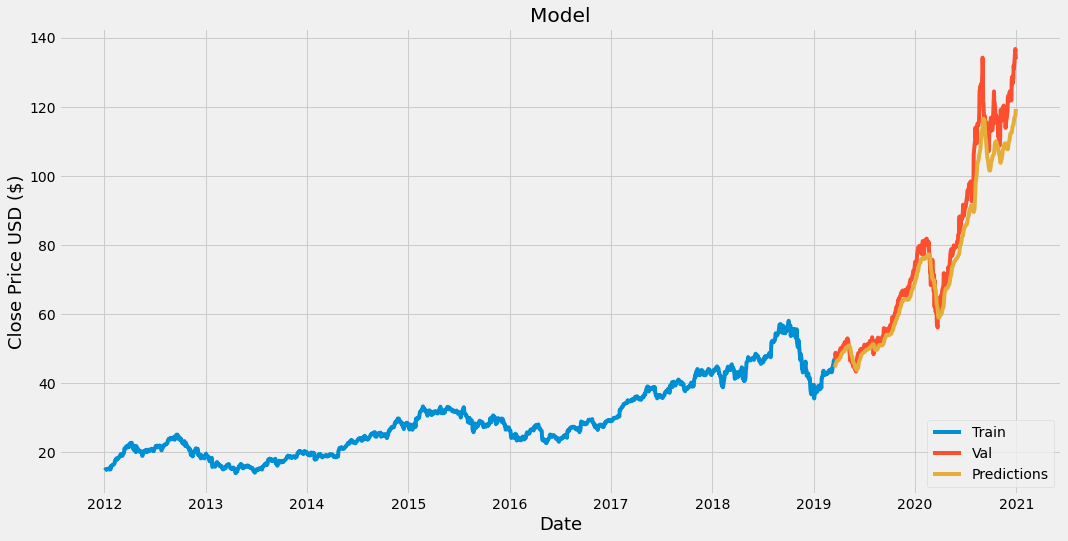

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-03-19,46.632500,44.561569
2019-03-20,47.040001,44.921822
2019-03-21,48.772499,45.264420
2019-03-22,47.762501,45.708447
2019-03-25,47.185001,46.091022
...,...,...
2020-12-23,130.960007,115.956360
2020-12-24,131.970001,116.663284
2020-12-28,136.690002,117.371933


In [ ]:
 #Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-30 ')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[120.009705]]


In [ ]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-12-31', end='2020-12-31')
print(apple_quote2['Close'])

Date
2020-12-31    132.690002
2020-12-31    132.690002
Name: Close, dtype: float64
